In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu, ttest_rel, wilcoxon

In [2]:
# nav excel file
nav_file = r"c:\Users\Chris Yeung\Queen's University\Amoon Jamzad - Breast_navigated_iKnife\NaviKnife_SyncInfo.xlsx"

In [3]:
# read excel file
nav_df = pd.read_excel(nav_file)
print(len(nav_df))
nav_df.head()

47


,date,time,surgeon,CR#,case # (lump. Consent / mast iKnife),iKnife case #,Side,Slicer scene?,Position matrix?,Margin status (IDC),...,Breach before sync?,Breach after sync?,Breach time (min),Notes,cautery CSV?,iKnife CSV?,synch_chr2nav,synch_mod2nav,synch_chr2mod,Unnamed: 32
0,2018-10-16 00:00:00,NaN,Engel,443086.0,iknifeCase16 (palpable),16,R,1.0,1.0,Neg,...,1.0,0.0,NaN,NaN,0.0,1.0,62.423,NaN,NaN,NaN
1,2018-10-16 00:00:00,NaN,Engel,568588.0,iknifeCase17 (palpable),17,L,1.0,1.0,Neg,...,1.0,1.0,7.7,NaN,0.0,1.0,9.482,NaN,NaN,NaN
2,2018-10-16 00:00:00,NaN,Engel,633787.0,iknifeCase18 (palpable),18,L,1.0,1.0,Pos,...,1.0,1.0,"1.5, 2.2, 2.4, 3.3, 5.7, 7.9",NaN,0.0,1.0,-0.052,NaN,NaN,NaN
3,2021-09-30 00:00:00,NaN,Merchant,456472.0,NonPalpableCase55,93,L,1.0,1.0,Neg,...,1.0,1.0,"23.6, 24.6, 30.8, 38.5, 41.4, 45.75, 47.5, 47.7",NaN,0.0,1.0,0.291,NaN,NaN,NaN
4,2021-10-15 00:00:00,NaN,Engel,511692.0,NonPalpableCase56,94,R,1.0,1.0,Pos,...,0.0,0.0,NaN,"missing data, cautery never gets close to tumo...",0.0,0.0,NaN,NaN,NaN,NaN


Data cleaning and preprocessing.

In [4]:
# replace "-" with NaN
nav_df = nav_df.replace('-', np.nan)
nav_df.head()

,date,time,surgeon,CR#,case # (lump. Consent / mast iKnife),iKnife case #,Side,Slicer scene?,Position matrix?,Margin status (IDC),...,Breach before sync?,Breach after sync?,Breach time (min),Notes,cautery CSV?,iKnife CSV?,synch_chr2nav,synch_mod2nav,synch_chr2mod,Unnamed: 32
0,2018-10-16 00:00:00,NaN,Engel,443086.0,iknifeCase16 (palpable),16,R,1.0,1.0,Neg,...,1.0,0.0,NaN,NaN,0.0,1.0,62.423,NaN,NaN,NaN
1,2018-10-16 00:00:00,NaN,Engel,568588.0,iknifeCase17 (palpable),17,L,1.0,1.0,Neg,...,1.0,1.0,7.7,NaN,0.0,1.0,9.482,NaN,NaN,NaN
2,2018-10-16 00:00:00,NaN,Engel,633787.0,iknifeCase18 (palpable),18,L,1.0,1.0,Pos,...,1.0,1.0,"1.5, 2.2, 2.4, 3.3, 5.7, 7.9",NaN,0.0,1.0,-0.052,NaN,NaN,NaN
3,2021-09-30 00:00:00,NaN,Merchant,456472.0,NonPalpableCase55,93,L,1.0,1.0,Neg,...,1.0,1.0,"23.6, 24.6, 30.8, 38.5, 41.4, 45.75, 47.5, 47.7",NaN,0.0,1.0,0.291,NaN,NaN,NaN
4,2021-10-15 00:00:00,NaN,Engel,511692.0,NonPalpableCase56,94,R,1.0,1.0,Pos,...,0.0,0.0,NaN,"missing data, cautery never gets close to tumo...",0.0,0.0,NaN,NaN,NaN,NaN


In [5]:
# remove columns after Notes
nav_df = nav_df.loc[:, :'Notes']
# remove specified columns
cols_to_rm = ["time", "CR#", "case # (lump. Consent / mast iKnife)", "Slicer scene?", "Position matrix?"]
nav_df = nav_df.drop(cols_to_rm, axis=1)
nav_df.head()

,date,surgeon,iKnife case #,Side,Margin status (IDC),Margin status (DCIS),Location of +,Close margin?,Location of close margin,+ or close?,...,+ or close in needle direction?,Nav tumor vol (cm3),Nav tumor dimensions (SI x ML x AP cm),US tumor dimensions (cm),Tumor dimensions (cm),Specimen dimensions (cm),Breach before sync?,Breach after sync?,Breach time (min),Notes
0,2018-10-16 00:00:00,Engel,16,R,Neg,Pos,"anterior, lateral",Pos,anterior,1.0,...,NaN,2.56,1.9 x 1.4 x 1.7,2.5 x 2.5 x 2.5,1.9 x 2.6 x 1.1,3.9 x 4.1 x 2.4,1.0,0.0,NaN,NaN
1,2018-10-16 00:00:00,Engel,17,L,Neg,Neg,NaN,Pos,lateral,1.0,...,True,8.55,2.5 x 3.1 x 2.7,1.3 x 1.6 x 1.4,1.8 x 1.2 x 1.0,7.3 x 7.5 x 3,1.0,1.0,7.7,NaN
2,2018-10-16 00:00:00,Engel,18,L,Pos,Neg,posterior,NaN,NaN,1.0,...,True,13.29,3.1 x 3.2 x 3.3,2.5 x 2.5 x 2.5,2.7 x 2.7 x 2.7; 0.6 x 0.6 x 0.5,6.5 x 6.5 x 4,1.0,1.0,"1.5, 2.2, 2.4, 3.3, 5.7, 7.9",NaN
3,2021-09-30 00:00:00,Merchant,93,L,Neg,Neg,NaN,Pos,superior,1.0,...,False,0.92,1.3 x 1.3 x 1.5,1 x 1.4 x 0.9,1.2 x 1 x 0.9,2.1 x 6 x 5.5,1.0,1.0,"23.6, 24.6, 30.8, 38.5, 41.4, 45.75, 47.5, 47.7",NaN
4,2021-10-15 00:00:00,Engel,94,R,Pos,Neg,lateral,NaN,NaN,1.0,...,False,0.51,1.3 x 0.7 x 1.1,0.9 x 0.9 x 0.9,0.9 x 0.8 x 0.5,6 x 7.1 x 2.1,0.0,0.0,NaN,"missing data, cautery never gets close to tumo..."


In [6]:
# remove rows without a tumor model in the nav
nav_df = nav_df.dropna(subset=['Nav tumor dimensions (SI x ML x AP cm)'])
print(len(nav_df))
nav_df.head()

29


,date,surgeon,iKnife case #,Side,Margin status (IDC),Margin status (DCIS),Location of +,Close margin?,Location of close margin,+ or close?,...,+ or close in needle direction?,Nav tumor vol (cm3),Nav tumor dimensions (SI x ML x AP cm),US tumor dimensions (cm),Tumor dimensions (cm),Specimen dimensions (cm),Breach before sync?,Breach after sync?,Breach time (min),Notes
0,2018-10-16 00:00:00,Engel,16,R,Neg,Pos,"anterior, lateral",Pos,anterior,1.0,...,NaN,2.56,1.9 x 1.4 x 1.7,2.5 x 2.5 x 2.5,1.9 x 2.6 x 1.1,3.9 x 4.1 x 2.4,1.0,0.0,NaN,NaN
1,2018-10-16 00:00:00,Engel,17,L,Neg,Neg,NaN,Pos,lateral,1.0,...,True,8.55,2.5 x 3.1 x 2.7,1.3 x 1.6 x 1.4,1.8 x 1.2 x 1.0,7.3 x 7.5 x 3,1.0,1.0,7.7,NaN
2,2018-10-16 00:00:00,Engel,18,L,Pos,Neg,posterior,NaN,NaN,1.0,...,True,13.29,3.1 x 3.2 x 3.3,2.5 x 2.5 x 2.5,2.7 x 2.7 x 2.7; 0.6 x 0.6 x 0.5,6.5 x 6.5 x 4,1.0,1.0,"1.5, 2.2, 2.4, 3.3, 5.7, 7.9",NaN
3,2021-09-30 00:00:00,Merchant,93,L,Neg,Neg,NaN,Pos,superior,1.0,...,False,0.92,1.3 x 1.3 x 1.5,1 x 1.4 x 0.9,1.2 x 1 x 0.9,2.1 x 6 x 5.5,1.0,1.0,"23.6, 24.6, 30.8, 38.5, 41.4, 45.75, 47.5, 47.7",NaN
4,2021-10-15 00:00:00,Engel,94,R,Pos,Neg,lateral,NaN,NaN,1.0,...,False,0.51,1.3 x 0.7 x 1.1,0.9 x 0.9 x 0.9,0.9 x 0.8 x 0.5,6 x 7.1 x 2.1,0.0,0.0,NaN,"missing data, cautery never gets close to tumo..."


In [7]:
# reset index
nav_df = nav_df.reset_index(drop=True)
nav_df.head(10)

,date,surgeon,iKnife case #,Side,Margin status (IDC),Margin status (DCIS),Location of +,Close margin?,Location of close margin,+ or close?,...,+ or close in needle direction?,Nav tumor vol (cm3),Nav tumor dimensions (SI x ML x AP cm),US tumor dimensions (cm),Tumor dimensions (cm),Specimen dimensions (cm),Breach before sync?,Breach after sync?,Breach time (min),Notes
0,2018-10-16 00:00:00,Engel,16,R,Neg,Pos,"anterior, lateral",Pos,anterior,1.0,...,NaN,2.56,1.9 x 1.4 x 1.7,2.5 x 2.5 x 2.5,1.9 x 2.6 x 1.1,3.9 x 4.1 x 2.4,1.0,0.0,NaN,NaN
1,2018-10-16 00:00:00,Engel,17,L,Neg,Neg,NaN,Pos,lateral,1.0,...,True,8.55,2.5 x 3.1 x 2.7,1.3 x 1.6 x 1.4,1.8 x 1.2 x 1.0,7.3 x 7.5 x 3,1.0,1.0,7.7,NaN
2,2018-10-16 00:00:00,Engel,18,L,Pos,Neg,posterior,NaN,NaN,1.0,...,True,13.29,3.1 x 3.2 x 3.3,2.5 x 2.5 x 2.5,2.7 x 2.7 x 2.7; 0.6 x 0.6 x 0.5,6.5 x 6.5 x 4,1.0,1.0,"1.5, 2.2, 2.4, 3.3, 5.7, 7.9",NaN
3,2021-09-30 00:00:00,Merchant,93,L,Neg,Neg,NaN,Pos,superior,1.0,...,False,0.92,1.3 x 1.3 x 1.5,1 x 1.4 x 0.9,1.2 x 1 x 0.9,2.1 x 6 x 5.5,1.0,1.0,"23.6, 24.6, 30.8, 38.5, 41.4, 45.75, 47.5, 47.7",NaN
4,2021-10-15 00:00:00,Engel,94,R,Pos,Neg,lateral,NaN,NaN,1.0,...,False,0.51,1.3 x 0.7 x 1.1,0.9 x 0.9 x 0.9,0.9 x 0.8 x 0.5,6 x 7.1 x 2.1,0.0,0.0,NaN,"missing data, cautery never gets close to tumo..."
5,2021-12-10 00:00:00,Walker,100,R,Neg,Neg,NaN,Pos,anterior,1.0,...,True,0.98,1.1 x 1.9 x 1.2,1.7 x 1.4 x 1.8,2 x 1.5 x 1.5,8.5 x 6.7 x 2.5,1.0,0.0,NaN,NaN
6,2021-12-14 00:00:00,Engel,102,R,Neg,Neg,NaN,Neg,NaN,0.0,...,NaN,4.31,2.0 x 2.3 x 2.0,1.4 x 1.4 x 1.4,1.2 x 1 x 0.8,NaN,1.0,1.0,14.4,NaN
7,2021-12-16 00:00:00,Merchant,103,R,Neg,Neg,NaN,Pos,posterior,1.0,...,True,2.01,1.9 x 1.8 x 1.5,1.2 x 1.3 x 1.4,2.3 x 1.6 x 3,5.3 x 6.5 x 3.3,1.0,1.0,"23.1, 23.8, 24.5",NaN
8,2022-02-16 00:00:00,Walker,109,R,Neg,Neg,NaN,Neg,NaN,0.0,...,NaN,0.69,0.8 x 1.5 x 1.2,0.5 x 0.5 x 0.5,0.7 x 0.5 x 0.5,6 x 7.3 x 2.5,0.0,0.0,NaN,tracking split into 3 recordings (last 3 in fo...
9,2022-03-10 00:00:00,Walker,110,R,Neg,Neg,NaN,Neg,NaN,0.0,...,NaN,1.12,1.4 x 1.4 x 1.1,0.7 x 0.8 x 0.9,1.2 x 1.1 x 0.6,5.9 x 7 x 2.9,1.0,0.0,NaN,tracking split into 4 recordings


In [8]:
def calculate_volume(dimensions):
    total_volume = 0
    if pd.isnull(dimensions):
        return
    for dim in dimensions.split(';'):
        si, ml, ap = map(float, dim.split('x'))
        volume = (4/3) * math.pi * (si/2) * (ml/2) * (ap/2)
        total_volume += volume
    return total_volume

nav_df['Nav tumor volume (cm3)'] = nav_df['Nav tumor dimensions (SI x ML x AP cm)'].apply(calculate_volume)
nav_df['Tumor volume (cm3)'] = nav_df['Tumor dimensions (cm)'].apply(calculate_volume)
nav_df['Specimen volume (cm3)'] = nav_df['Specimen dimensions (cm)'].apply(calculate_volume)

nav_df.head()

,date,surgeon,iKnife case #,Side,Margin status (IDC),Margin status (DCIS),Location of +,Close margin?,Location of close margin,+ or close?,...,US tumor dimensions (cm),Tumor dimensions (cm),Specimen dimensions (cm),Breach before sync?,Breach after sync?,Breach time (min),Notes,Nav tumor volume (cm3),Tumor volume (cm3),Specimen volume (cm3)
0,2018-10-16 00:00:00,Engel,16,R,Neg,Pos,"anterior, lateral",Pos,anterior,1.0,...,2.5 x 2.5 x 2.5,1.9 x 2.6 x 1.1,3.9 x 4.1 x 2.4,1.0,0.0,NaN,NaN,2.367714,2.845236,20.093627
1,2018-10-16 00:00:00,Engel,17,L,Neg,Neg,NaN,Pos,lateral,1.0,...,1.3 x 1.6 x 1.4,1.8 x 1.2 x 1.0,7.3 x 7.5 x 3,1.0,1.0,7.7,NaN,10.956304,1.130973,86.001099
2,2018-10-16 00:00:00,Engel,18,L,Pos,Neg,posterior,NaN,NaN,1.0,...,2.5 x 2.5 x 2.5,2.7 x 2.7 x 2.7; 0.6 x 0.6 x 0.5,6.5 x 6.5 x 4,1.0,1.0,"1.5, 2.2, 2.4, 3.3, 5.7, 7.9",NaN,17.140530,10.400242,88.488193
3,2021-09-30 00:00:00,Merchant,93,L,Neg,Neg,NaN,Pos,superior,1.0,...,1 x 1.4 x 0.9,1.2 x 1 x 0.9,2.1 x 6 x 5.5,1.0,1.0,"23.6, 24.6, 30.8, 38.5, 41.4, 45.75, 47.5, 47.7",NaN,1.327323,0.565487,36.285395
4,2021-10-15 00:00:00,Engel,94,R,Pos,Neg,lateral,NaN,NaN,1.0,...,0.9 x 0.9 x 0.9,0.9 x 0.8 x 0.5,6 x 7.1 x 2.1,0.0,0.0,NaN,"missing data, cautery never gets close to tumo...",0.524122,0.188496,46.841146


Compare difference in specimen and nav tumor dimensions between false positive group and true negative group.

In [9]:
# Filter the dataframe based on the given conditions
df_tn = nav_df[(nav_df['Margin status (IDC)'] == 'Neg') & 
             (nav_df['Margin status (DCIS)'] == 'Neg') & 
             (nav_df['Specimen volume (cm3)'].notna()) & 
             (nav_df['Breach time (min)'].isna())]

df_fp = nav_df[(nav_df['Margin status (IDC)'] == 'Neg') & 
             (nav_df['Margin status (DCIS)'] == 'Neg') & 
             (nav_df['Specimen volume (cm3)'].notna()) & 
             (nav_df['Breach time (min)'].notna())]

In [10]:
# Display the first few rows of each dataframe
print("DataFrame 1 (true negatives):")
print(len(df_tn))
df_tn.head()

DataFrame 1 (true negatives):
7


,date,surgeon,iKnife case #,Side,Margin status (IDC),Margin status (DCIS),Location of +,Close margin?,Location of close margin,+ or close?,...,US tumor dimensions (cm),Tumor dimensions (cm),Specimen dimensions (cm),Breach before sync?,Breach after sync?,Breach time (min),Notes,Nav tumor volume (cm3),Tumor volume (cm3),Specimen volume (cm3)
5,2021-12-10 00:00:00,Walker,100,R,Neg,Neg,NaN,Pos,anterior,1.0,...,1.7 x 1.4 x 1.8,2 x 1.5 x 1.5,8.5 x 6.7 x 2.5,1.0,0.0,NaN,NaN,1.313186,2.356194,74.547376
8,2022-02-16 00:00:00,Walker,109,R,Neg,Neg,NaN,Neg,NaN,0.0,...,0.5 x 0.5 x 0.5,0.7 x 0.5 x 0.5,6 x 7.3 x 2.5,0.0,0.0,NaN,tracking split into 3 recordings (last 3 in fo...,0.753982,0.091630,57.334066
9,2022-03-10 00:00:00,Walker,110,R,Neg,Neg,NaN,Neg,NaN,0.0,...,0.7 x 0.8 x 0.9,1.2 x 1.1 x 0.6,5.9 x 7 x 2.9,1.0,0.0,NaN,tracking split into 4 recordings,1.128879,0.414690,62.711425
14,2022-04-07 00:00:00,Walker,115,R,Neg,Neg,NaN,Neg,NaN,0.0,...,0.5 x 0.7 x 0.5,1.5 x 1.3 x 0.6,5.2 x 7 x 2.8,0.0,0.0,NaN,NaN,0.212058,0.612611,53.365187
16,2022-06-02 00:00:00,Walker,117,R,Neg,Neg,NaN,Neg,NaN,0.0,...,1 x 0.4 x 0.6,0.9 x 0.9 x 0.4,8.2 x 6.3 x 1.8,0.0,0.0,NaN,NaN,0.565487,0.169646,48.688403


In [11]:
print("\nDataFrame 2 (false positives):")
print(len(df_fp))
df_fp.head()


DataFrame 2 (false positives):
7


,date,surgeon,iKnife case #,Side,Margin status (IDC),Margin status (DCIS),Location of +,Close margin?,Location of close margin,+ or close?,...,US tumor dimensions (cm),Tumor dimensions (cm),Specimen dimensions (cm),Breach before sync?,Breach after sync?,Breach time (min),Notes,Nav tumor volume (cm3),Tumor volume (cm3),Specimen volume (cm3)
1,2018-10-16 00:00:00,Engel,17,L,Neg,Neg,NaN,Pos,lateral,1.0,...,1.3 x 1.6 x 1.4,1.8 x 1.2 x 1.0,7.3 x 7.5 x 3,1.0,1.0,7.7,NaN,10.956304,1.130973,86.001099
3,2021-09-30 00:00:00,Merchant,93,L,Neg,Neg,NaN,Pos,superior,1.0,...,1 x 1.4 x 0.9,1.2 x 1 x 0.9,2.1 x 6 x 5.5,1.0,1.0,"23.6, 24.6, 30.8, 38.5, 41.4, 45.75, 47.5, 47.7",NaN,1.327323,0.565487,36.285395
7,2021-12-16 00:00:00,Merchant,103,R,Neg,Neg,NaN,Pos,posterior,1.0,...,1.2 x 1.3 x 1.4,2.3 x 1.6 x 3,5.3 x 6.5 x 3.3,1.0,1.0,"23.1, 23.8, 24.5",NaN,2.686062,5.780530,59.525327
10,2022-03-24 00:00:00,Walker,111,L,Neg,Neg,NaN,Neg,NaN,0.0,...,0.7 x 0.7 x 0.7,0.9 x 0.7 x 0.5,7.8 x 8 x 3.8,1.0,1.0,"19.05, 31.6",NaN,2.345723,0.164934,124.155742
12,2022-03-29 00:00:00,Engel,113,R,Neg,Neg,NaN,Neg,NaN,0.0,...,1 x 1.3 x 1.1,1.8 x 1.0 x 0.6,4.2 x 6.5 x 3.5,1.0,1.0,"6.7, 7.2, 7.4, 8.4, 11.2, 20.55",NaN,10.225884,0.565487,50.029863


U-statistic: 22.0, P-value: 0.8047785547785549


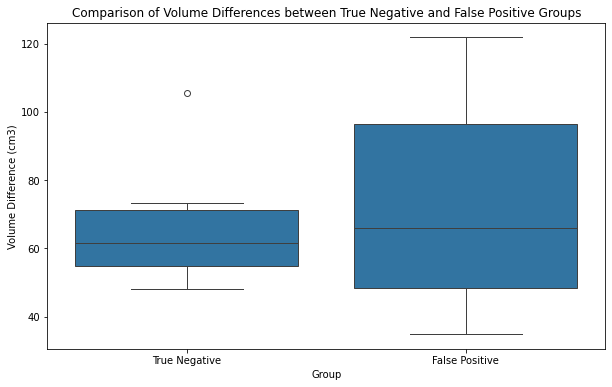

In [12]:
# Calculate the difference between "Specimen volume (cm3)" and "Nav tumor volume (cm3)"
df_tn = df_tn.copy()
df_fp = df_fp.copy()
df_tn['Volume Difference (cm3)'] = df_tn['Specimen volume (cm3)'] - df_tn['Nav tumor volume (cm3)']
df_fp['Volume Difference (cm3)'] = df_fp['Specimen volume (cm3)'] - df_fp['Nav tumor volume (cm3)']

# Perform a Mann-Whitney U test to compare the means of the differences
u_stat, p_value = mannwhitneyu(df_tn['Volume Difference (cm3)'], df_fp['Volume Difference (cm3)'])
print(f"U-statistic: {u_stat}, P-value: {p_value}")

# Combine the data for plotting
df_tn['Group'] = 'True Negative'
df_fp['Group'] = 'False Positive'
combined_df = pd.concat([df_tn, df_fp])

# Plot the data in a grouped box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Volume Difference (cm3)', data=combined_df)
plt.title('Comparison of Volume Differences between True Negative and False Positive Groups')
plt.ylabel('Volume Difference (cm3)')
plt.xlabel('Group')
plt.show()

Mean Nav tumor volume (cm3) in filtered group: 3.9564806480271884
Mean Tumor volume (cm3) in filtered group: 2.2636858065178886
W-statistic (filtered group): 93.0, P-value (filtered group): 0.01102352887392044


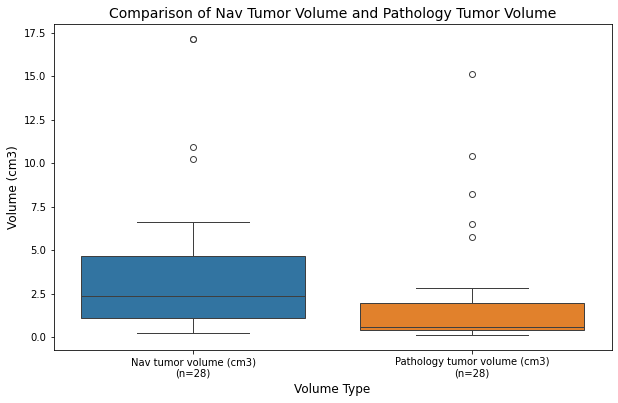

In [13]:
# Filter the dataframe to include only rows with non-nan values in both "Nav tumor volume (cm3)" and "Tumor volume (cm3)" columns
filtered_nav_df = nav_df.dropna(subset=['Nav tumor volume (cm3)', 'Tumor volume (cm3)'])

# Combine the data for plotting
filtered_nav_df_melted = filtered_nav_df.melt(value_vars=['Nav tumor volume (cm3)', 'Tumor volume (cm3)'], 
                                              var_name='Volume Type', value_name='Volume (cm3)')

# Calculate the counts for each group
group_counts = filtered_nav_df_melted['Volume Type'].value_counts()

# Calculate the mean volumes
mean_nav_volume_filtered = filtered_nav_df['Nav tumor volume (cm3)'].mean()
mean_tumor_volume_filtered = filtered_nav_df['Tumor volume (cm3)'].mean()

print(f"Mean Nav tumor volume (cm3) in filtered group: {mean_nav_volume_filtered}")
print(f"Mean Tumor volume (cm3) in filtered group: {mean_tumor_volume_filtered}")

# Perform a Wilcoxon signed-rank test to compare the means
w_stat_filtered, p_value_filtered = wilcoxon(filtered_nav_df['Nav tumor volume (cm3)'], filtered_nav_df['Tumor volume (cm3)'])
print(f"W-statistic (filtered group): {w_stat_filtered}, P-value (filtered group): {p_value_filtered}")

# Combine the data for plotting
filtered_nav_df_melted = filtered_nav_df.melt(value_vars=['Nav tumor volume (cm3)', 'Tumor volume (cm3)'], 
                                              var_name='Volume Type', value_name='Volume (cm3)')

# Plot the data in a box plot with larger font and different colors for the two groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='Volume Type', y='Volume (cm3)', hue='Volume Type', data=filtered_nav_df_melted, palette=['#1f77b4', '#ff7f0e'], legend=False)

# Add counts to the x-axis labels
plt.title('Comparison of Nav Tumor Volume and Pathology Tumor Volume', fontsize=14)
plt.ylabel('Volume (cm3)', fontsize=12)
plt.xlabel('Volume Type', fontsize=12)
plt.xticks(ticks=[0, 1], labels=[f'Nav tumor volume (cm3)\n(n={group_counts["Nav tumor volume (cm3)"]})', 
                                 f'Pathology tumor volume (cm3)\n(n={group_counts["Tumor volume (cm3)"]})'])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Mean Nav tumor volume (cm3) in filtered group: 5.152700644077819
Mean Tumor volume (cm3) in filtered group: 2.8674363346865244
W-statistic (filtered group): 31.0, P-value (filtered group): 0.10699462890625


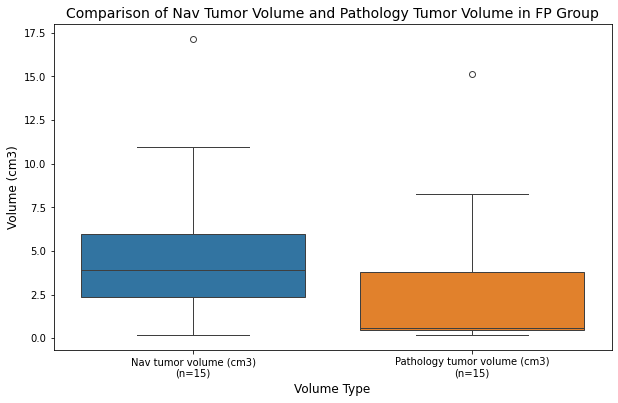

In [14]:
# Filter the dataframe based on the given conditions
filtered_nav_df = nav_df[(nav_df['Margin status (IDC)'] == 'Neg') & 
                         (nav_df['Margin status (DCIS)'] == 'Neg') & 
                         (nav_df['Breach time (min)'].notna())]

# Filter the dataframe to include only rows with non-nan values in both "Nav tumor volume (cm3)" and "Tumor volume (cm3)" columns
filtered_nav_df = filtered_nav_df.dropna(subset=['Nav tumor volume (cm3)', 'Tumor volume (cm3)'])

# Calculate the mean volumes
mean_nav_volume_filtered = filtered_nav_df['Nav tumor volume (cm3)'].mean()
mean_tumor_volume_filtered = filtered_nav_df['Tumor volume (cm3)'].mean()

print(f"Mean Nav tumor volume (cm3) in filtered group: {mean_nav_volume_filtered}")
print(f"Mean Tumor volume (cm3) in filtered group: {mean_tumor_volume_filtered}")

# Perform a Wilcoxon signed-rank test to compare the means
w_stat_filtered, p_value_filtered = wilcoxon(filtered_nav_df['Nav tumor volume (cm3)'], filtered_nav_df['Tumor volume (cm3)'])
print(f"W-statistic (filtered group): {w_stat_filtered}, P-value (filtered group): {p_value_filtered}")

# Combine the data for plotting
filtered_nav_df_melted = filtered_nav_df.melt(value_vars=['Nav tumor volume (cm3)', 'Tumor volume (cm3)'], 
                                              var_name='Volume Type', value_name='Volume (cm3)')

# Calculate the counts for each group
group_counts = filtered_nav_df_melted['Volume Type'].value_counts()

# Plot the data in a box plot with larger font and different colors for the two groups
plt.figure(figsize=(10, 6))
sns.boxplot(x='Volume Type', y='Volume (cm3)', hue='Volume Type', data=filtered_nav_df_melted, palette=['#1f77b4', '#ff7f0e'], legend=False)
plt.title('Comparison of Nav Tumor Volume and Pathology Tumor Volume in FP Group', fontsize=14)
plt.ylabel('Volume (cm3)', fontsize=12)
plt.xlabel('Volume Type', fontsize=12)
plt.xticks(ticks=[0, 1], labels=[f'Nav tumor volume (cm3)\n(n={group_counts["Nav tumor volume (cm3)"]})', 
                                 f'Pathology tumor volume (cm3)\n(n={group_counts["Tumor volume (cm3)"]})'])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Mean Nav tumor volume (cm3) for True Negative group: 0.8988694980521083
Mean Nav tumor volume (cm3) for False Positive group: 4.62038519552956


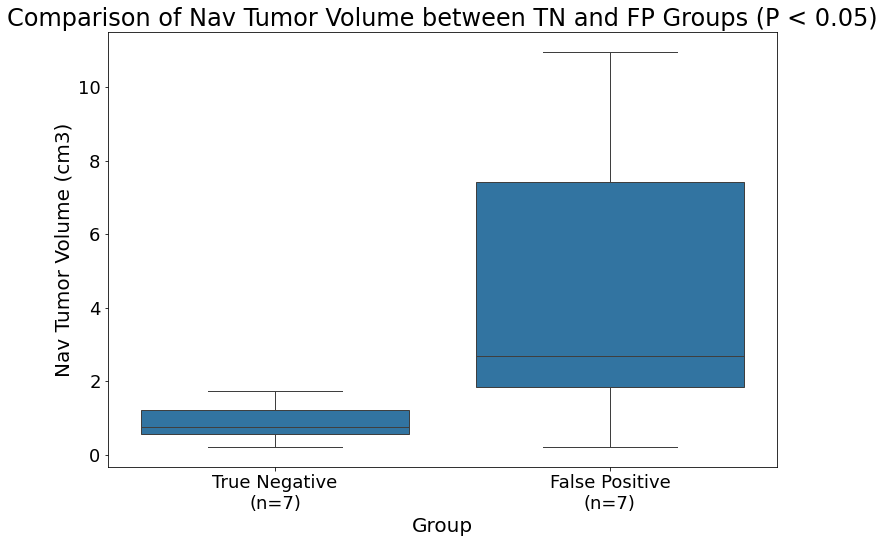

U-statistic (Nav tumor volume): 8.0, P-value (Nav tumor volume): 0.03787878787878788


In [15]:
# Calculate the mean nav tumor volume for each group
mean_nav_volume_tn = df_tn['Nav tumor volume (cm3)'].mean()
mean_nav_volume_fp = df_fp['Nav tumor volume (cm3)'].mean()

print(f"Mean Nav tumor volume (cm3) for True Negative group: {mean_nav_volume_tn}")
print(f"Mean Nav tumor volume (cm3) for False Positive group: {mean_nav_volume_fp}")

# Combine the data for plotting
df_tn['Group'] = 'True Negative'
df_fp['Group'] = 'False Positive'
combined_nav_volume_df = pd.concat([df_tn[['Nav tumor volume (cm3)', 'Group']], df_fp[['Nav tumor volume (cm3)', 'Group']]])

# Plot the data in a box plot with much larger font sizes
plt.figure(figsize=(12, 8))
sns.boxplot(x='Group', y='Nav tumor volume (cm3)', data=combined_nav_volume_df)
plt.title('Comparison of Nav Tumor Volume between TN and FP Groups (P < 0.05)', fontsize=24)
plt.ylabel('Nav Tumor Volume (cm3)', fontsize=20)
plt.xlabel('Group', fontsize=20)
plt.xticks(ticks=[0, 1], labels=[f'True Negative\n(n={len(df_tn)})', f'False Positive\n(n={len(df_fp)})'], fontsize=18)
plt.yticks(fontsize=18)
plt.show()

# Perform a Mann-Whitney U test to compare the means of the nav tumor volumes
u_stat_nav, p_value_nav = mannwhitneyu(df_tn['Nav tumor volume (cm3)'], df_fp['Nav tumor volume (cm3)'])
print(f"U-statistic (Nav tumor volume): {u_stat_nav}, P-value (Nav tumor volume): {p_value_nav}")

Mean Normalized Nav tumor volume for True Negative group: 3.1631656597370887
Mean Normalized Nav tumor volume for False Positive group: 6.849425333120985


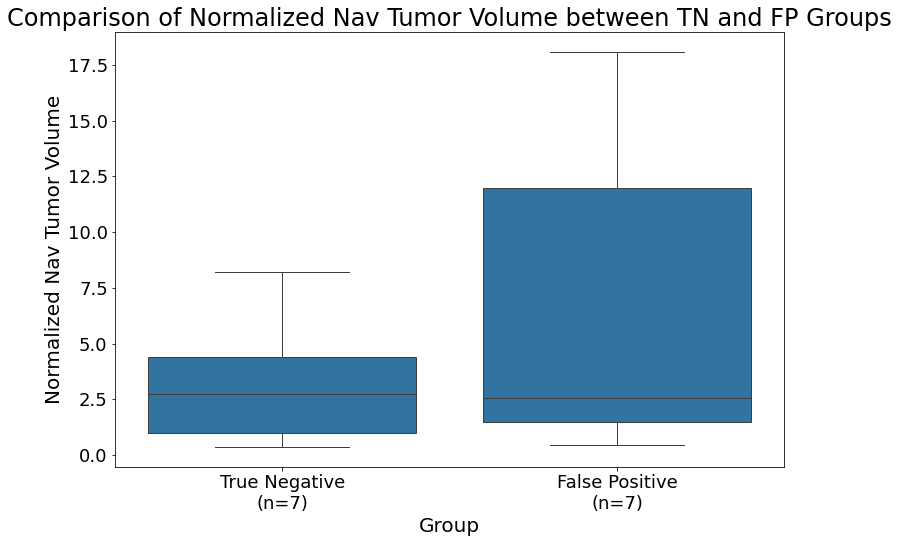

U-statistic (Normalized Nav tumor volume): 19.0, P-value (Normalized Nav tumor volume): 0.534965034965035


In [ ]:
# Normalize the "Nav tumor volume (cm3)" by the "Tumor volume (cm3)"
df_tn['Normalized Nav tumor volume'] = df_tn['Nav tumor volume (cm3)'] / df_tn['Tumor volume (cm3)']
df_fp['Normalized Nav tumor volume'] = df_fp['Nav tumor volume (cm3)'] / df_fp['Tumor volume (cm3)']

# Calculate the mean normalized nav tumor volume for each group
mean_normalized_nav_volume_tn = df_tn['Normalized Nav tumor volume'].mean()
mean_normalized_nav_volume_fp = df_fp['Normalized Nav tumor volume'].mean()

print(f"Mean Normalized Nav tumor volume for True Negative group: {mean_normalized_nav_volume_tn}")
print(f"Mean Normalized Nav tumor volume for False Positive group: {mean_normalized_nav_volume_fp}")

# Combine the data for plotting
df_tn['Group'] = 'True Negative'
df_fp['Group'] = 'False Positive'
combined_normalized_nav_volume_df = pd.concat([df_tn[['Normalized Nav tumor volume', 'Group']], df_fp[['Normalized Nav tumor volume', 'Group']]])

# Plot the data in a box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Group', y='Normalized Nav tumor volume', data=combined_normalized_nav_volume_df)
plt.title('Comparison of Normalized Nav Tumor Volume between TN and FP Groups')
plt.ylabel('Normalized Nav Tumor Volume')
plt.xlabel('Group')
plt.xticks(ticks=[0, 1], labels=[f'True Negative\n(n={len(df_tn)})', f'False Positive\n(n={len(df_fp)})'])
plt.show()

# Perform a Mann-Whitney U test to compare the means of the normalized nav tumor volumes
u_stat_normalized_nav, p_value_normalized_nav = mannwhitneyu(df_tn['Normalized Nav tumor volume'], df_fp['Normalized Nav tumor volume'])
print(f"U-statistic (Normalized Nav tumor volume): {u_stat_normalized_nav}, P-value (Normalized Nav tumor volume): {p_value_normalized_nav}")

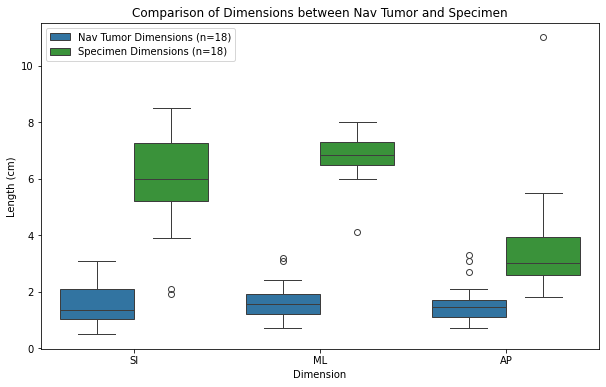

In [17]:
# Function to extract individual dimensions from the dataframe
def extract_dimensions(df, column_name):
    si_list, ml_list, ap_list = [], [], []
    for dim in df[column_name].dropna():
        for sub_dim in dim.split(';'):
            si, ml, ap = map(float, sub_dim.split('x'))
            si_list.append(si)
            ml_list.append(ml)
            ap_list.append(ap)
    return si_list, ml_list, ap_list

# Filter out rows with NaN values in "Specimen dimensions (cm)"
filtered_nav_df = nav_df.dropna(subset=['Specimen dimensions (cm)'])

# Extract dimensions for "Nav tumor dimensions"
nav_si, nav_ml, nav_ap = extract_dimensions(filtered_nav_df, 'Nav tumor dimensions (SI x ML x AP cm)')
assert len(nav_si) == len(nav_ml) == len(nav_ap)

# Extract dimensions for "Specimen dimensions (cm)" from the filtered dataframe
specimen_si, specimen_ml, specimen_ap = extract_dimensions(filtered_nav_df, 'Specimen dimensions (cm)')
assert len(specimen_si) == len(specimen_ml) == len(specimen_ap)

# Create a dataframe to store the dimensions
dimensions_df = pd.DataFrame({
    'Dimension': ['SI'] * len(nav_si) + ['ML'] * len(nav_ml) + ['AP'] * len(nav_ap),
    'Nav Tumor Dimensions': nav_si + nav_ml + nav_ap,
    'Specimen Dimensions': specimen_si + specimen_ml + specimen_ap
})

# Melt the dataframe for easier plotting with seaborn
dimensions_melted = dimensions_df.melt(id_vars='Dimension', var_name='Group', value_name='Dimension Value')

# Plot the dimensions using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dimension', y='Dimension Value', hue='Group', data=dimensions_melted, palette={'Nav Tumor Dimensions': '#1f77b4', 'Specimen Dimensions': '#2ca02c'})

# Add the number of samples to the legend
handles, labels = plt.gca().get_legend_handles_labels()
nav_count = len(nav_si)
specimen_count = len(specimen_si)
labels[0] = f'Nav Tumor Dimensions (n={nav_count})'
labels[1] = f'Specimen Dimensions (n={specimen_count})'
plt.legend(handles, labels)

plt.title('Comparison of Dimensions between Nav Tumor and Specimen')
plt.ylabel('Length (cm)')
plt.xlabel('Dimension')
plt.show()

In [18]:
# Calculate the mean length of each dimension for both groups
mean_nav_dimensions = dimensions_df.groupby('Dimension')['Nav Tumor Dimensions'].mean()
mean_specimen_dimensions = dimensions_df.groupby('Dimension')['Specimen Dimensions'].mean()

# Print the mean lengths
print("Mean lengths of each dimension for Nav Tumor Dimensions:")
print(mean_nav_dimensions)
print("\nMean lengths of each dimension for Specimen Dimensions:")
print(mean_specimen_dimensions)
# Calculate the difference in mean lengths between the two groups
dimension_difference = mean_specimen_dimensions - mean_nav_dimensions

# Print the differences
print("\nDifference in mean lengths of each dimension between Specimen and Nav Tumor Dimensions:")
print(dimension_difference)

Mean lengths of each dimension for Nav Tumor Dimensions:
Dimension
AP    1.600000
ML    1.661111
SI    1.611111
Name: Nav Tumor Dimensions, dtype: float64

Mean lengths of each dimension for Specimen Dimensions:
Dimension
AP    3.638889
ML    6.772222
SI    5.866667
Name: Specimen Dimensions, dtype: float64

Difference in mean lengths of each dimension between Specimen and Nav Tumor Dimensions:
Dimension
AP    2.038889
ML    5.111111
SI    4.255556
dtype: float64


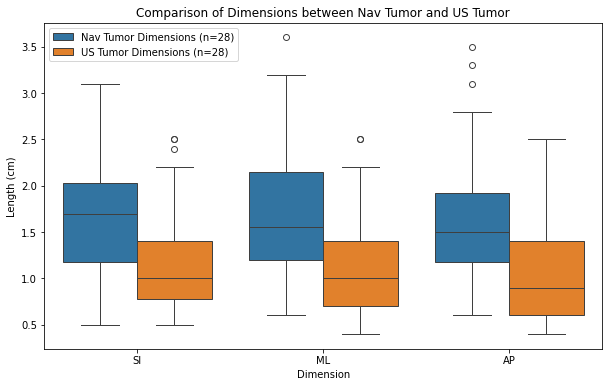

Mean lengths of each dimension for Nav Tumor Dimensions:
Dimension
AP    1.692857
ML    1.717857
SI    1.653571
Name: Nav Tumor Dimensions, dtype: float64

Mean lengths of each dimension for US Tumor Dimensions:
Dimension
AP    1.103571
ML    1.110714
SI    1.175000
Name: US Tumor Dimensions, dtype: float64

Difference in mean lengths of each dimension between US Tumor and Nav Tumor Dimensions:
Dimension
AP   -0.589286
ML   -0.607143
SI   -0.478571
dtype: float64


In [ ]:
filtered_nav_df = nav_df.dropna(subset=['Nav tumor dimensions (SI x ML x AP cm)', 'US tumor dimensions (cm)'])

# Extract dimensions for "US tumor dimensions"
us_si, us_ml, us_ap = extract_dimensions(filtered_nav_df, 'US tumor dimensions (cm)')
assert len(us_si) == len(us_ml) == len(us_ap)

# Extract dimensions for "Nav tumor dimensions"
nav_si, nav_ml, nav_ap = extract_dimensions(filtered_nav_df, 'Nav tumor dimensions (SI x ML x AP cm)')
assert len(nav_si) == len(nav_ml) == len(nav_ap)

# Create a dataframe to store the dimensions
us_dimensions_df = pd.DataFrame({
    'Dimension': ['SI'] * len(nav_si) + ['ML'] * len(nav_ml) + ['AP'] * len(nav_ap),
    'Nav Tumor Dimensions': nav_si + nav_ml + nav_ap,
    'US Tumor Dimensions': us_si + us_ml + us_ap
})

# Melt the dataframe for easier plotting with seaborn
us_dimensions_melted = us_dimensions_df.melt(id_vars='Dimension', var_name='Group', value_name='Dimension Value')

# Plot the dimensions using boxplots
plt.figure(figsize=(10, 6))
sns.boxplot(x='Dimension', y='Dimension Value', hue='Group', data=us_dimensions_melted, palette={'Nav Tumor Dimensions': '#1f77b4', 'US Tumor Dimensions': '#ff7f0e'})

# Add the number of samples to the legend
handles, labels = plt.gca().get_legend_handles_labels()
nav_count = len(nav_si)
us_count = len(us_si)
labels[0] = f'Nav Tumor Dimensions (n={nav_count})'
labels[1] = f'US Tumor Dimensions (n={us_count})'
plt.legend(handles, labels)

plt.title('Comparison of Dimensions between Nav Tumor and US Tumor')
plt.ylabel('Length (cm)')
plt.xlabel('Dimension')
plt.show()

# Calculate the mean length of each dimension for both groups
mean_nav_dimensions_us = us_dimensions_df.groupby('Dimension')['Nav Tumor Dimensions'].mean()
mean_us_dimensions = us_dimensions_df.groupby('Dimension')['US Tumor Dimensions'].mean()

# Print the mean lengths
print("Mean lengths of each dimension for Nav Tumor Dimensions:")
print(mean_nav_dimensions_us)
print("\nMean lengths of each dimension for US Tumor Dimensions:")
print(mean_us_dimensions)

# Calculate the difference in mean lengths between the two groups
us_dimension_difference = mean_us_dimensions - mean_nav_dimensions_us

# Print the differences
print("\nDifference in mean lengths of each dimension between US Tumor and Nav Tumor Dimensions:")
print(us_dimension_difference)

In [22]:
from scipy.stats import wilcoxon

# Perform Wilcoxon signed-rank test for each dimension
si_stat, si_p_value = wilcoxon(nav_si, us_si)
ml_stat, ml_p_value = wilcoxon(nav_ml, us_ml)
ap_stat, ap_p_value = wilcoxon(nav_ap, us_ap)

# Print the results
print(f"SI Dimension - W-statistic: {si_stat}, P-value: {si_p_value}")
print(f"ML Dimension - W-statistic: {ml_stat}, P-value: {ml_p_value}")
print(f"AP Dimension - W-statistic: {ap_stat}, P-value: {ap_p_value}")

SI Dimension - W-statistic: 54.0, P-value: 0.0011758982597414316
ML Dimension - W-statistic: 35.0, P-value: 0.00021436874484796888
AP Dimension - W-statistic: 53.0, P-value: 0.0003059804439544678


c:\ProgramData\Anaconda3\envs\pt2\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  res = hypotest_fun_out(*samples, **kwds)
